<a href="https://colab.research.google.com/github/khbae/trading/blob/master/07_Newey_West.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Newey-West Standard Error

* https://en.wikipedia.org/wiki/Newey%E2%80%93West_estimator
* http://www.vincentgregoire.com/standard-errors-in-python/
* https://github.com/statsmodels/statsmodels

This note introduces the newey-west estimator that corrects standard errors in case of heteroscedasticity and autocorrelation in residuals. In the Gauss-Markov world, the OLS estimation and variance covariance matrix is a good and best estimate. However, there are some unrealistic assumptions (e.g. Homoscedasticity, and No Autocorrelation) in the Gauss-Markor setting. **These problems make it hard to believe the OLS regression results.** In short, we cannot trust the statistical significance(three stars) we found through OLS regressions. So we will break two assumptions in the Gauss Markov world. And we will find correct standard errors that lead to more accurate statistical inference.

Consider a predictive regression model:

$$ r_{t+1} = \alpha + \beta x_t + \varepsilon_{t+1} $$


In [0]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import statsmodels.stats.sandwich_covariance as sw
import statsmodels.stats.api as sms
import statsmodels.stats.stattools as smt
from statsmodels.compat import lzip

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Read sample data from Petersen's website.
* http://www.kellogg.northwestern.edu/faculty/petersen/htm/papers/se/test_data.txt

In [0]:
dat = pd.read_csv("http://www.kellogg.northwestern.edu/faculty/petersen/htm/papers/se/test_data.txt",header=None,sep='\s+',names=['firm','year','x','y'])
dat.head()

,firm,year,x,y
0,1,1,-1.113973,2.251535
1,1,2,-0.080854,1.242346
2,1,3,-0.237607,-1.426376
3,1,4,-0.152486,-1.109394
4,1,5,-0.001426,0.914686


## Ordinary Least Squares Regression

$$ y_i = \alpha + \beta x_i + \varepsilon_i$$



* https://en.wikipedia.org/wiki/Ordinary_least_squares

### OLS Assumptions
* Correct specification
* Strict exogeneity: $ E[\varepsilon|X]=0$
* No linear dependence
* **Homoscedasticity:** $ E[\varepsilon_i|X]=\sigma^2 $
* **No autocorrelation:** $ E[\varepsilon_i \varepsilon_j|X]=0$
* Normality: $ \varepsilon|X$ ~ $N(0,\sigma^2 I_n)$

In [0]:
xvar = np.random.normal(0,1,1000)
ep = np.random.normal(0,2,1000)
yvar = 2 + 0 * xvar + ep

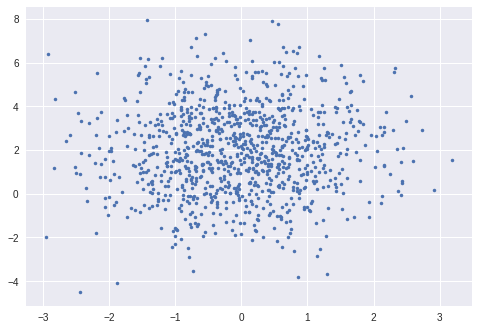

In [0]:
plt.plot(xvar,yvar,'.')

In [0]:
dat2 = pd.DataFrame(np.c_[xvar,yvar],columns=['xvar','yvar'])
dat2.head()
results = sm.ols(formula = 'yvar ~ xvar',data=dat2).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   yvar   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.638
Date:                Fri, 09 Feb 2018   Prob (F-statistic):              0.201
Time:                        08:07:35   Log-Likelihood:                -2106.2
No. Observations:                1000   AIC:                             4216.
Df Residuals:                     998   BIC:                             4226.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9590      0.063     31.078      0.0

In [0]:
ols_results = sm.ols(formula='y ~ x', data=dat).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     1311.
Date:                Fri, 09 Feb 2018   Prob (F-statistic):          4.25e-255
Time:                        08:10:31   Log-Likelihood:                -10573.
No. Observations:                5000   AIC:                         2.115e+04
Df Residuals:                    4998   BIC:                         2.116e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0297      0.028      1.047      0.2

## Heteroskedasticity tests for the residuals

### Breush-Pagan Test
* https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test
* Null Hypothesis: homoskedasticity
* If the p-value is less than 0.05, we rejects the Null hypothesis with 5% significance level.

In [0]:
name = ['Lagrange multiplier statistic','p-value','f-value', 'f p-value']
test = sms.het_breuschpagan(ols_results.resid, ols_results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 0.19056170748876777),
 ('p-value', 0.6624495239271655),
 ('f-value', 0.19049274293047413),
 ('f p-value', 0.662525680575091)]

### Goldfeld-Quandt Test
* https://en.wikipedia.org/wiki/Goldfeld%E2%80%93Quandt_test
* Null Hypothesis: homoskedasticity
* If the p-value is less than 0.05, we rejects the Null hypothesis with 5% significance level.

In [0]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(ols_results.resid, ols_results.model.exog)
lzip(name, test)

[('F statistic', 0.9986459411522116), ('p-value', 0.5135045953054642)]

## Autocorrelation tests for the residuals

### Durbin–Watson statistic

* https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic
* http://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html

"The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals. Thus, for r == 0, indicating no serial correlation, the test statistic equals 2. This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation."

In [0]:
test = smt.durbin_watson(ols_results.resid)
print(test)

1.0961212409592467


## Correct Standard Errors with Newey-West Method

In [0]:
newey_west = sm.ols(formula='y~x',data=dat).fit(cov_type='HAC', cov_kwds={'maxlags':10})
#newey_west = sm.ols(formula='y~x',data=dat).fit(cov_type='HAC', cov_kwds={'maxlags':10})
print(newey_west.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     542.5
Date:                Fri, 09 Feb 2018   Prob (F-statistic):          5.27e-114
Time:                        08:23:59   Log-Likelihood:                -10573.
No. Observations:                5000   AIC:                         2.115e+04
Df Residuals:                    4998   BIC:                         2.116e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0297      0.057      0.519      0.6

## Other Example: Greene Econometrics Textbook 
* http://k-park.tistory.com/attachment/cfile26.uf@99F375335A1CBFD508BE56.txt

In [0]:
dat2 = pd.read_csv("http://k-park.tistory.com/attachment/cfile26.uf@99F375335A1CBFD508BE56.txt",sep='\t')
dat2.head()

,gnp,invest,price,interest,year,r_gnp,r_invest,rate,r_int
0,637.7,97.4,0.7277,3.55,1964,876.322660,133.846365,1.534812,2.015188
1,691.1,113.5,0.7436,4.04,1965,929.397526,152.635826,2.184966,1.855034
2,756.0,125.7,0.7676,4.50,1966,984.887962,163.757165,3.227542,1.272458
3,799.6,122.8,0.7906,4.19,1967,1011.383759,155.325070,2.996352,1.193648
4,873.4,133.3,0.8254,5.16,1968,1058.153622,161.497456,4.401720,0.758280


In [0]:
green_results = sm.ols(formula='r_invest~r_int + r_gnp',data=dat2).fit()
print(green_results.summary())

                            OLS Regression Results                            
Dep. Variable:               r_invest   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     35.03
Date:                Fri, 09 Feb 2018   Prob (F-statistic):           1.43e-06
Time:                        08:34:24   Log-Likelihood:                -79.391
No. Observations:                  19   AIC:                             164.8
Df Residuals:                      16   BIC:                             167.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.5336     24.915     -0.503      0.6

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


In [0]:
name = ['Lagrange multiplier statistic','p-value','f-value', 'f p-value']
test = sms.het_breuschpagan(green_results.resid, green_results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 4.215484566321315),
 ('p-value', 0.12151199665668992),
 ('f-value', 2.281026840673353),
 ('f p-value', 0.13440887690544684)]

In [0]:
green_results = sm.ols(formula='r_invest~r_int + r_gnp',data=dat2).fit(cov_type='HAC', cov_kwds={'maxlags':4})
print(green_results.summary())

                            OLS Regression Results                            
Dep. Variable:               r_invest   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     51.20
Date:                Fri, 09 Feb 2018   Prob (F-statistic):           1.11e-07
Time:                        08:36:21   Log-Likelihood:                -79.391
No. Observations:                  19   AIC:                             164.8
Df Residuals:                      16   BIC:                             167.6
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.5336     18.958     -0.661      0.5

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
